# I. Info

Tên đội thi: ANANAS
- Mã Thuỳ Anh
- Nhan Hữu Hiếu
- Trương Thành Nhân

# II. Get Started

## 1. Import

In [ ]:
%pip install --extra-index-url https://fiinquant.github.io/fiinquantx/simple fiinquantx
%pip install optuna pandas_ta lightgbm
%pip install "numpy<2"

In [2]:
# Thư viện chuẩn của Python
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime, timedelta

# Thư viện của bên thứ ba
import FiinQuantX as fq
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pandas_ta as ta
import plotly.graph_objects as go
import seaborn as sns
from dotenv import load_dotenv
from plotly.subplots import make_subplots
from sklearn.metrics import (classification_report, f1_score,
                             precision_recall_curve, roc_auc_score)
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime
import time
import json

In [3]:
# Set seed để tái tạo kết quả
import os, random, numpy as np

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

## 2. Config

In [ ]:
load_dotenv()
username = os.getenv("API_USERNAME")
password = os.getenv("API_PASSWORD")

try:
    print("Logging in...")
    
    client = fq.FiinSession(username=username, password=password).login()
    print("Login successful!")
except Exception as e:
    print(f"Login error: {e}")
    exit()

# III. Tasks

## 1. Fetch data

In [ ]:
def save_ticker_list(client, index_code, filename, output_dir="ticker_lists"):
    """Fetch a ticker list for a given index and save it as CSV."""
    tickers = client.TickerList(ticker=index_code)
    print(f"{index_code} has {len(tickers)} tickers. Example: {tickers[:5]}")
    
    df = pd.DataFrame(tickers, columns=['ticker'])
    filepath = os.path.join(output_dir, filename)
    df.to_csv(filepath, index=False, encoding='utf-8-sig')
    print(f"   Saved to file: {filepath}")

OUTPUT_DIR = "ticker_lists"
os.makedirs(OUTPUT_DIR, exist_ok=True)

try:
    print("\nFetching ticker lists using TickerList...")
    exchanges = [
        ("VNINDEX", "hose_tickers.csv"),
        ("HNXINDEX", "hnx_tickers.csv"),
        ("UPCOMINDEX", "upcom_tickers.csv")
    ]
    
    for index_code, filename in exchanges:
        save_ticker_list(client, index_code, filename, OUTPUT_DIR)

except Exception as e:
    print(f"Error while fetching ticker lists: {e}")

print(f"\nProcess completed! All CSV files saved in '{OUTPUT_DIR}'.")


In [ ]:
client = fq.FiinSession(username=username, password=password).login()

def fetch_range_batch(tickers, start, end):
    try:
        df = client.Fetch_Trading_Data(
            realtime=False,
            tickers=tickers,
            fields=["open", "high", "low", "close", "volume"],
            adjusted=True,
            by="1d",
            from_date=start.strftime("%Y-%m-%d"),
            to_date=end.strftime("%Y-%m-%d")
        ).get_data()
        return pd.DataFrame(df)
    except Exception as e:
        print(f"Error in batch {tickers[:3]}...: {e}")
        return pd.DataFrame()

def fetch_exchange_fast(exchange, file, batch_size=100, max_workers=5):
    tickers = pd.read_csv(file).iloc[:,0].dropna().tolist()
    all_data = []
    today = datetime.today()
    start = today - timedelta(days=365*3)

    while start < today:
        end = min(start + timedelta(days=90), today)
        print(f"\nFetching {exchange}: {start.date()} → {end.date()} ({len(tickers)} tickers)")

        batches = [tickers[i:i+batch_size] for i in range(0, len(tickers), batch_size)]

        futures = []
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            for batch in batches:
                futures.append(executor.submit(fetch_range_batch, batch, start, end))

            for future in as_completed(futures):
                df = future.result()
                if not df.empty:
                    all_data.append(df)

        start = end + timedelta(days=1)

    if all_data:
        df_all = pd.concat(all_data, ignore_index=True)
        out_path = f"{exchange.lower()}_all_by1d.parquet"
        df_all.to_parquet(out_path, index=False, engine="pyarrow", compression="zstd")
        print(f"Saved {out_path}, {len(df_all)} rows, {df_all['ticker'].nunique()} tickers")
    else:
        print(f"No data was fetched for the {exchange} exchange")

fetch_exchange_fast("HOSE", "ticker_lists/hose_tickers.csv")
fetch_exchange_fast("HNX", "ticker_lists/hnx_tickers.csv")
fetch_exchange_fast("UPCOM", "ticker_lists/upcom_tickers.csv")

## 2. Calc FA - TA

### 2.1 FA

In [ ]:

def safe_ta(func, *args, **kwargs):
    try:
        res = func(*args, **kwargs)
        if res is None:
            return pd.Series([np.nan]*len(args[0]))
        if isinstance(res, pd.DataFrame) and res.empty:
            return pd.DataFrame(np.nan, index=args[0].index, columns=res.columns)
        return res
    except Exception:
        return pd.Series([np.nan]*len(args[0]))

def add_all_indicators_with_patterns(group):
    group = group.set_index("timestamp").sort_index()
    
    close = group["close"].astype(float)
    open_ = group["open"].astype(float)
    high = group["high"].astype(float)
    low = group["low"].astype(float)
    volume = group["volume"].astype(float)

    if len(close) >= 20: group["MA20"] = safe_ta(ta.sma, close, length=20)
    if len(close) >= 50: group["MA50"] = safe_ta(ta.sma, close, length=50)
    if len(close) >= 200: group["MA200"] = safe_ta(ta.sma, close, length=200)

    if len(close) >= 35:
        macd = safe_ta(ta.macd, close, fast=12, slow=26, signal=9)
        if isinstance(macd, pd.DataFrame):
            group["MACD"] = macd.get("MACD_12_26_9")
            group["MACD_signal"] = macd.get("MACDs_12_26_9")
            group["MACD_hist"] = macd.get("MACDh_12_26_9")

    adx = safe_ta(ta.adx, high, low, close, length=14)
    if isinstance(adx, pd.DataFrame):
        group["ADX"] = adx.get("ADX_14")
        group['DMP'] = adx.get('DMP_14')
        group['DMN'] = adx.get('DMN_14')

    group["RSI14"] = safe_ta(ta.rsi, close, length=14)
    stoch = safe_ta(ta.stoch, high, low, close, k=14, d=3, smooth_k=3)
    if isinstance(stoch, pd.DataFrame):
        group["Stoch_K"] = stoch.get("STOCHk_14_3_3")
        group["Stoch_D"] = stoch.get("STOCHd_14_3_3")

    bbands = safe_ta(ta.bbands, close, length=20, std=2)
    if isinstance(bbands, pd.DataFrame):
        group["BB_upper"] = bbands.get("BBU_20_2.0")
        group["BB_middle"] = bbands.get("BBM_20_2.0")
        group["BB_lower"] = bbands.get("BBL_20_2.0")
    group["ATR14"] = safe_ta(ta.atr, high, low, close, length=14)

    group["MFI"] = safe_ta(ta.mfi, high, low, close, volume, length=14)
    group["OBV"] = safe_ta(ta.obv, close, volume)
    group["VWAP"] = safe_ta(ta.vwap, high, low, close, volume)

    group["Prev_Close"] = close.shift(1)
    group["Gap"] = ((open_ - group["Prev_Close"].fillna(open_)) / group["Prev_Close"].fillna(open_)) * 100

    group["Doji"] = (abs(close - open_) <= (high - low) * 0.1).astype(int)
    group["Hammer"] = (
        ((close > open_) & ((open_ - low) >= 2 * abs(close - open_))) |
        ((open_ > close) & ((close - low) >= 2 * abs(close - open_)))
    ).astype(int)

    prev_open, prev_close = open_.shift(1), close.shift(1)
    group["Bullish_Engulfing"] = (
        (prev_close < prev_open) & (close > open_) & (close > prev_open) & (open_ < prev_close)
    ).astype(int)
    group["Bearish_Engulfing"] = (
        (prev_close > prev_open) & (close < open_) & (close < prev_open) & (open_ > prev_close)
    ).astype(int)

    if len(close) >= 10: group["EMA10"] = safe_ta(ta.ema, close, length=10)
    if len(close) >= 20: group["EMA20"] = safe_ta(ta.ema, close, length=20)
    if len(close) >= 50: group["EMA50"] = safe_ta(ta.ema, close, length=50)
    if len(close) >= 14: group["WMA14"] = safe_ta(ta.wma, close, length=14)

    psar = safe_ta(ta.psar, high, low, close, step=0.02, max_step=0.2)
    if isinstance(psar, pd.DataFrame):
        group['PSAR'] = psar.get('PSAR_0.02_0.2')
        group['PSAR_up'] = psar.get('PSARl_0.02_0.2')
        group['PSAR_down'] = psar.get('PSARs_0.02_0.2')

    ichimoku_res = safe_ta(ta.ichimoku, high, low, close, tenkan=9, kijun=26, senkou=52)
    if isinstance(ichimoku_res, tuple):
        ichimoku_res_clean = [x.reset_index(drop=True) for x in ichimoku_res if x is not None and not x.empty]
        if ichimoku_res_clean:
            ichimoku_df = pd.concat(ichimoku_res_clean, axis=1)
            if not ichimoku_df.empty:
                group['Tenkan_sen'] = ichimoku_df.get('ITS_9')
                group['Kijun_sen'] = ichimoku_df.get('IKS_26')
                group['Senkou_Span_A'] = ichimoku_df.get('ISA_9_26')
                group['Senkou_Span_B'] = ichimoku_df.get('ISB_26_52')
                group['Chikou_Span'] = ichimoku_df.get('ICS_26')

    if len(close) >= 20: group["CCI20"] = safe_ta(ta.cci, high, low, close, length=20)

    aroon = safe_ta(ta.aroon, high, low, length=25)
    if isinstance(aroon, pd.DataFrame):
        group['Aroon_Up'] = aroon.get('AROONU_25')
        group['Aroon_Down'] = aroon.get('AROOND_25')
        group['Aroon_Oscillator'] = aroon.get('AROONOSC_25')

    supertrend = safe_ta(ta.supertrend, high, low, close, length=14, multiplier=3.0)
    if isinstance(supertrend, pd.DataFrame):
        group['Supertrend'] = supertrend.get('SUPERT_14_3.0')
        group['Supertrend_direction'] = supertrend.get('SUPERTd_14_3.0')

    return group.reset_index()

def process_exchange(exchange: str, parquet_file: str):
    print(f"\n--- STARTING TECHNICAL INDICATOR APPLICATION: {exchange} ---")
    try:
        df = pd.read_parquet(parquet_file)
    except FileNotFoundError:
        print(f"Error: File {parquet_file} not found. Skipping {exchange} exchange.")
        return None

    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.dropna(subset=["timestamp"])

    df = df.sort_values(["ticker", "timestamp"])

    df_ind = df.groupby("ticker", group_keys=False).apply(add_all_indicators_with_patterns)

    out_path = f"{exchange.lower()}_with_indicators_patterns.parquet"
    df_ind.to_parquet(out_path, index=False, engine="pyarrow", compression="zstd")
    print(f"Saved {out_path}, {len(df_ind)} rows, {df_ind['ticker'].nunique()} tickers")
    return df_ind

process_exchange("HOSE", "hose_all_by1d.parquet")
process_exchange("HNX", "hnx_all_by1d.parquet")
process_exchange("UPCOM", "upcom_all_by1d.parquet")


--- STARTING TECHNICAL INDICATOR APPLICATION: HOSE ---
Saved hose_with_indicators_patterns.parquet, 301848 rows, 412 tickers

--- STARTING TECHNICAL INDICATOR APPLICATION: HNX ---
Saved hnx_with_indicators_patterns.parquet, 226271 rows, 304 tickers

--- STARTING TECHNICAL INDICATOR APPLICATION: UPCOM ---
Saved upcom_with_indicators_patterns.parquet, 642912 rows, 889 tickers


,timestamp,ticker,open,high,low,close,volume,MA20,MA50,MA200,...,Kijun_sen,Senkou_Span_A,Senkou_Span_B,Chikou_Span,CCI20,Aroon_Up,Aroon_Down,Aroon_Oscillator,Supertrend,Supertrend_direction
0,2022-09-05,A32,25098.504282,25098.504282,25098.504282,25098.504282,0.0,NaN,NaN,NaN,...,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-09-06,A32,21647.459944,26510.295148,21647.459944,23268.666455,300.0,NaN,NaN,NaN,...,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-09-07,A32,26588.727974,26745.593626,26588.727974,26691.474976,1600.0,NaN,NaN,NaN,...,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-09-08,A32,22902.385158,22902.385158,22823.952332,22863.168745,600.0,NaN,NaN,NaN,...,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-09-09,A32,22902.385158,22902.385158,22902.385158,22902.385158,0.0,NaN,NaN,NaN,...,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,2025-08-25,YTC,35400.000000,35400.000000,35400.000000,35400.000000,0.0,36218.85,36780.1124,36652.047547,...,NaN,None,None,NaN,34086.383817,16.0,60.0,-44.0,39930.735270,-1.0
743,2025-08-26,YTC,35400.000000,35400.000000,35400.000000,35400.000000,0.0,35948.85,36911.7084,36577.864597,...,NaN,None,None,NaN,33758.078546,12.0,56.0,-44.0,39640.661130,-1.0
744,2025-08-27,YTC,35400.000000,35400.000000,35400.000000,35400.000000,0.0,35678.85,37039.3292,36491.507597,...,NaN,None,None,NaN,33084.180510,8.0,52.0,-44.0,39337.756763,-1.0
745,2025-08-28,YTC,35400.000000,35400.000000,35400.000000,35400.000000,0.0,35408.85,37166.9500,36402.666097,...,NaN,None,None,NaN,31252.139819,4.0,48.0,-44.0,39056.488423,-1.0


### 2.2 TA

### Calc and Clean data

In [ ]:
load_dotenv()
API_USERNAME = os.getenv("API_USERNAME")
API_PASSWORD = os.getenv("API_PASSWORD")

TA_INPUT_DIR = "."
FINAL_OUTPUT_DIR = "final_data"
os.makedirs(FINAL_OUTPUT_DIR, exist_ok=True)

FILE_CONFIG = [
    {'input': 'hose_with_indicators_patterns.parquet', 'output': 'hose_final.parquet'},
    {'input': 'hnx_with_indicators_patterns.parquet', 'output': 'hnx_final.parquet'},
    {'input': 'upcom_with_indicators_patterns.parquet', 'output': 'upcom_final.parquet'}
]
FA_LATEST_YEAR = 2025
FA_NUMBER_OF_PERIODS = 13
FA_BATCH_SIZE = 100

def fetch_fa_data_robustly(fa_client, tickers):
    """Fetches FA data by batch, falling back to single-ticker requests if a batch fails."""
    all_fa_records = []
    ticker_batches = [tickers[i:i + FA_BATCH_SIZE] for i in range(0, len(tickers), FA_BATCH_SIZE)]
    print(f"Fetching FA data for {len(tickers)} tickers in {len(ticker_batches)} batches...")
    
    for i, batch in enumerate(ticker_batches):
        try:
            fa_raw_batch = fa_client.get_ratios(
                tickers=batch, TimeFilter="Quarterly", LatestYear=FA_LATEST_YEAR,
                NumberOfPeriod=FA_NUMBER_OF_PERIODS, Consolidated=True
            )
            if fa_raw_batch:
                all_fa_records.extend(fa_raw_batch)
            time.sleep(0.5)
        except Exception as e:
            print(f"    -> Batch {i+1} failed: {e}. Switching to single-ticker mode for this batch.")
            for ticker in batch:
                try:
                    fa_raw_single = fa_client.get_ratios(
                        tickers=[ticker], TimeFilter="Quarterly", LatestYear=FA_LATEST_YEAR,
                        NumberOfPeriod=FA_NUMBER_OF_PERIODS, Consolidated=True
                    )
                    if fa_raw_single:
                        all_fa_records.extend(fa_raw_single)
                except Exception:
                    # Silently skip invalid tickers
                    pass
    return all_fa_records

def process_and_clean(df_ta, df_fa_master):
    """Merges, cleans _x/_y columns, and flattens dictionary columns in one go."""
    # Merge
    df_merged = pd.merge_asof(
        df_ta.sort_values('timestamp'),
        df_fa_master.sort_values('timestamp'),
        on='timestamp', by='ticker', direction='backward'
    )
    
    # Clean _x, _y columns
    cols_x = [col for col in df_merged.columns if col.endswith('_x')]
    for col_x in cols_x:
        base_name, col_y = col_x[:-2], f"{col_x[:-2]}_y"
        if col_y in df_merged.columns:
            df_merged[base_name] = df_merged[col_y].fillna(df_merged[col_x])
            df_merged = df_merged.drop(columns=[col_x, col_y])
        else:
            df_merged = df_merged.rename(columns={col_x: base_name})

    # Flatten dictionary columns
    cols_to_flatten = [col for col in df_merged.columns if 'Ratio' in col and df_merged[col].apply(lambda x: isinstance(x, dict)).any()]
    if not cols_to_flatten:
        return df_merged
        
    df_processed = df_merged.copy()
    for col_name in cols_to_flatten:
        series_normalized = df_processed[col_name].apply(lambda x: x if isinstance(x, dict) else {})
        normalized_df = pd.json_normalize(series_normalized)
        normalized_df.index = df_processed.index
        df_processed = pd.concat([df_processed, normalized_df], axis=1)
    
    return df_processed.drop(columns=cols_to_flatten)

try:
    print("Logging in...")
    client = fq.FiinSession(username=API_USERNAME, password=API_PASSWORD).login()
    fa_client = client.FundamentalAnalysis()
except Exception as e:
    print(f"Fatal error during login: {e}"); exit()

all_tickers = set()
for config in FILE_CONFIG:
    file_path = os.path.join(TA_INPUT_DIR, config['input'])
    if os.path.exists(file_path):
        all_tickers.update(pd.read_parquet(file_path)['ticker'].unique())
unique_tickers = sorted(list(all_tickers))

if not unique_tickers:
    print("Error: No tickers found in source files."); exit()

raw_fa_data = fetch_fa_data_robustly(fa_client, unique_tickers)

if not raw_fa_data:
    print("Error: No FA data could be fetched."); exit()
    
print(f"\nSuccessfully fetched {len(raw_fa_data)} FA records.")
flattened_list = []
for record in raw_fa_data:
    try:
        flat_record = {'ticker': record.get('ticker'), 'year': record.get('year'), 'quarter': record.get('quarter')}
        for group_values in record.values():
            if isinstance(group_values, dict):
                flat_record.update(group_values)
        flattened_list.append(flat_record)
    except Exception:
        continue
df_fa_master = pd.DataFrame(flattened_list)
df_fa_master['timestamp'] = pd.to_datetime(df_fa_master['year'].astype(int).astype(str) + 'Q' + df_fa_master['quarter'].astype(int).astype(str))

for config in FILE_CONFIG:
    input_file = os.path.join(TA_INPUT_DIR, config['input'])
    output_file = os.path.join(FINAL_OUTPUT_DIR, config['output'])
    
    if not os.path.exists(input_file):
        continue
        
    print(f"\nProcessing {config['input']}...")
    df_ta = pd.read_parquet(input_file)
    df_ta['timestamp'] = pd.to_datetime(df_ta['timestamp'])
    
    df_final = process_and_clean(df_ta, df_fa_master)
    
    df_final.to_parquet(output_file, index=False, engine="pyarrow", compression="zstd")
    print(f"  -> Saved final file to: {output_file}")

print(f"\nPipeline complete! Check results in the '{FINAL_OUTPUT_DIR}' directory.")

In [ ]:
DATA_DIR = "final_data"
os.makedirs(DATA_DIR, exist_ok=True)

FILES_TO_PROCESS = [
    "hose_final.parquet",
    "hnx_final.parquet",
    "upcom_final.parquet"
]

COLS_TO_FLATTEN_PREFIXES = [
    'ProfitabilityRatio', 'GrowthRatio', 'ValuationRatios', 'LiquidityRatio',
    'FinancialLeverageRatio', 'EfficiencyRatio', 'SolvencyRatio'
]

def parse_item(item):
    """Safely handles values that could be a dict, a JSON string, or other types."""
    if isinstance(item, dict):
        return item
    if isinstance(item, str):
        try:
            return json.loads(item.replace("'", "\""))
        except (json.JSONDecodeError, TypeError):
            return {}
    return {}

print("--- Starting Column Flattening Process ---")

for file_name in FILES_TO_PROCESS:
    file_path = os.path.join(DATA_DIR, file_name)
    
    if not os.path.exists(file_path):
        print(f"Warning: File not found, skipping: {file_path}")
        continue

    print(f"Processing: {file_name}...")
    df = pd.read_parquet(file_path)
    
    cols_to_flatten = [
        col for col in df.columns 
        if any(col.startswith(prefix) for prefix in COLS_TO_FLATTEN_PREFIXES)
    ]

    if not cols_to_flatten:
        print("  -> No specified columns to flatten found in this file.")
        continue
        
    df_processed = df.copy()
    for col_name in cols_to_flatten:
        normalized_df = pd.json_normalize(
            df_processed[col_name].apply(parse_item)
        )
        
        normalized_df.index = df_processed.index
        
        df_processed = pd.concat([df_processed, normalized_df], axis=1)
        df_processed = df_processed.drop(columns=[col_name])
    
    df_processed.to_parquet(file_path, index=False)

print(f"\nProcess complete! All files in the '{DATA_DIR}' directory have been updated.")

## 3. Apply ML

### NOTE
- Dữ liệu dùng để train là từ ngày cũ nhất trong data đến 2024-08-31
- Dữ liệu để để validate là từ 2024-08-31 đến 2024-12-31
- Dữ liệu để backtest là các cổ phiếu trong năm 2025

In [5]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

INPUT_DIR = "final_data"
OUTPUT_DIR = "model_artifacts"
os.makedirs(OUTPUT_DIR, exist_ok=True)

FILES_TO_PROCESS = [
    "hose_final.parquet",
    "hnx_final.parquet",
    "upcom_final.parquet"
]
print("Reading and concatenating data from the 3 exchanges...")
try:
    df = pd.concat([pd.read_parquet(os.path.join(INPUT_DIR, f)) for f in FILES_TO_PROCESS if os.path.exists(os.path.join(INPUT_DIR, f))], ignore_index=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values(['ticker', 'timestamp']).reset_index(drop=True)
except Exception as e:
    print(f"Error reading files: {e}"); exit()

print("Performing advanced feature engineering...")
feature_cols = [
    'MA20', 'MA50', 'MA200', 'MACD_hist', 'ADX', 'RSI14', 'Stoch_K', 
    'ATR14', 'MFI', 'OBV', 'VWAP', 'Gap', 'ROE', 'PriceToEarning', 
    'ROA', 'DebtToEquity', 'Revenue_Growth', 'netProfitGrowth'
]
available_features = [col for col in feature_cols if col in df.columns]
def create_advanced_features(group):
    for col in available_features:
        for lag in [1, 2, 3, 5]: group[f'{col}_lag_{lag}'] = group[col].shift(lag)
    for window in [5, 10, 20]:
        group[f'close_std_{window}'] = group['close'].rolling(window=window).std()
        if 'RSI14' in group.columns: group[f'rsi_mean_{window}'] = group['RSI14'].rolling(window=window).mean()
    for period in [1, 2, 3, 5, 10, 20]: group[f'return_{period}d'] = group['close'].pct_change(period)
    return group
df_featured = df.groupby('ticker', group_keys=False).apply(create_advanced_features)

print("Creating labels for the data...")
LOOK_FORWARD_DAYS = 15; PROFIT_THRESHOLD = 0.10; STOP_LOSS_THRESHOLD = 0.05
def create_labels(group):
    rolling_max = group['close'].rolling(window=LOOK_FORWARD_DAYS).max().shift(-LOOK_FORWARD_DAYS)
    rolling_min = group['close'].rolling(window=LOOK_FORWARD_DAYS).min().shift(-LOOK_FORWARD_DAYS)
    profit_target = (rolling_max / group['close']) - 1 >= PROFIT_THRESHOLD
    stop_loss_hit = (rolling_min / group['close']) - 1 < -STOP_LOSS_THRESHOLD
    group['label'] = np.where(profit_target & ~stop_loss_hit, 1.0, 0.0)
    group.loc[group['close'].shift(-LOOK_FORWARD_DAYS).isnull(), 'label'] = np.nan
    return group
df_labeled = df_featured.groupby('ticker', group_keys=False).apply(create_labels)

print(f"Saving processed data to '{OUTPUT_DIR}/data_for_backtest.parquet'...")
df_labeled.to_parquet(os.path.join(OUTPUT_DIR, 'data_for_backtest.parquet'))

print("Preparing and cleaning data for the model...")
COLS_TO_DROP = ['ticker', 'timestamp', 'label', 'open', 'high', 'low', 'close']
feature_cols_final = [col for col in df_labeled.columns if col not in COLS_TO_DROP and 'Ratio' not in col and 'Growth' != col]
X = df_labeled[feature_cols_final].copy()
y = df_labeled['label'].copy()
if 'exchange' in X.columns: X = pd.get_dummies(X, columns=['exchange'], prefix='exchange', drop_first=True)
valid_indices = y.dropna().index
X = X.loc[valid_indices].reset_index(drop=True)
y = y.loc[valid_indices].reset_index(drop=True)
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)
X.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X.columns]
print(f"Data preparation complete. {len(X):,} samples available for training and testing.")

Reading and concatenating data from the 3 exchanges...
Performing advanced feature engineering...
Creating labels for the data...
Saving processed data to 'model_artifacts/data_for_backtest.parquet'...
Preparing and cleaning data for the model...
Data preparation complete. 1,146,969 samples available for training and testing.


### Phase 1: Discovery - Finding important features and best parameters

Best parameters found with F1-Score: 0.4082


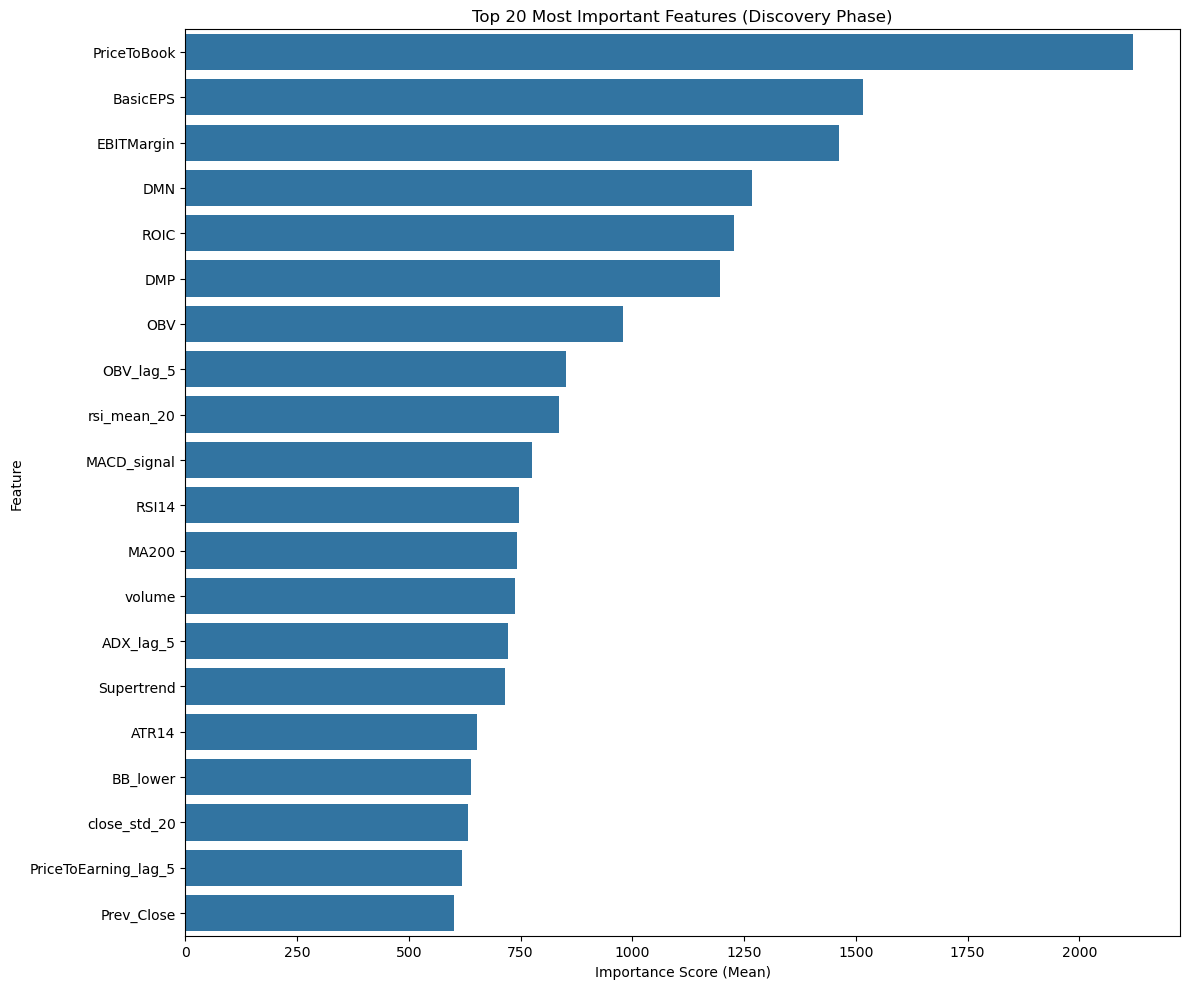

In [6]:
tscv_for_tuning = TimeSeriesSplit(n_splits=3, test_size=int(len(X)*0.1))
train_idx, val_idx = list(tscv_for_tuning.split(X))[-1]
X_train_tune, X_val_tune = X.iloc[train_idx], X.iloc[val_idx]
y_train_tune, y_val_tune = y.iloc[train_idx], y.iloc[val_idx]

def objective(trial):
    ratio = (y_train_tune == 0).sum() / (y_train_tune == 1).sum() if (y_train_tune == 1).sum() > 0 else 1
    param = {
        'objective': 'binary', 'metric': 'auc', 'verbosity': -1, 'boosting_type': 'gbdt',
        'n_estimators': 1000, 'scale_pos_weight': ratio, 'random_state': SEED, 'n_jobs': -1,
        'bagging_seed': SEED, 'feature_fraction_seed': SEED, 'data_random_seed': SEED,
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1)
    }
    model = lgb.LGBMClassifier(**param)
    model.fit(X_train_tune, y_train_tune,
              eval_set=[(X_val_tune, y_val_tune)],
              eval_metric='auc',
              callbacks=[lgb.early_stopping(50, verbose=False)])
    preds = model.predict(X_val_tune)
    f1 = f1_score(y_val_tune, preds)
    return f1
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=20)
best_params = study.best_params
print(f"Best parameters found with F1-Score: {study.best_value:.4f}")

N_SPLITS = 5
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
feature_importances = pd.DataFrame(index=X.columns)
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    ratio = (y_train == 0).sum() / (y_train == 1).sum() if (y_train == 1).sum() > 0 else 1
    lgb_clf = lgb.LGBMClassifier(objective='binary', metric='auc', n_estimators=1000,
                                 scale_pos_weight=ratio, random_state=SEED, n_jobs=-1,  bagging_seed=SEED, feature_fraction_seed=SEED, data_random_seed=SEED, **best_params)
    lgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='auc',
                callbacks=[lgb.early_stopping(100, verbose=False)])
    feature_importances[f'fold_{i+1}'] = lgb_clf.feature_importances_

feature_importances['mean'] = feature_importances.mean(axis=1)
feature_importances.sort_values('mean', ascending=False, inplace=True)
plt.figure(figsize=(12, 10))
sns.barplot(x='mean', y=feature_importances.index[:20], data=feature_importances.head(20))
plt.title('Top 20 Most Important Features (Discovery Phase)')
plt.xlabel('Importance Score (Mean)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Phase 2: Final model training

In [7]:
print("\n" + "="*30)
print("="*30)

TOP_N_FEATURES = 20 
top_features = feature_importances.head(TOP_N_FEATURES).index.tolist()
X_selected = X[top_features]
print(f"Selected the top {len(top_features)} features for retraining.")

original_timestamps = df_labeled.loc[valid_indices, 'timestamp'].reset_index(drop=True)

TRAIN_END_DATE = pd.to_datetime('2024-08-31')
VALIDATION_END_DATE = pd.to_datetime('2024-12-31')

train_mask = original_timestamps <= TRAIN_END_DATE
X_train_final = X_selected[train_mask]
y_train_final = y[train_mask]

validation_mask = (original_timestamps > TRAIN_END_DATE) & (original_timestamps <= VALIDATION_END_DATE)
X_val_final = X_selected[validation_mask]
y_val_final = y[validation_mask]

print(f"Train set: {len(X_train_final)} samples (from start to {TRAIN_END_DATE.date()})")
print(f"Validation set: {len(X_val_final)} samples (from {TRAIN_END_DATE.date() + pd.Timedelta(days=1)} to {VALIDATION_END_DATE.date()})")
if X_val_final.empty:
    print("Warning: The validation set is empty. Please check the date ranges and data.")
    exit()

ratio = (y_train_final == 0).sum() / (y_train_final == 1).sum() if (y_train_final == 1).sum() > 0 else 1
final_model = lgb.LGBMClassifier(
    objective='binary', metric='auc', n_estimators=2000,
    scale_pos_weight=ratio, random_state=SEED, n_jobs=-1,
    bagging_seed=SEED,                 
    feature_fraction_seed=SEED,       
    data_random_seed=SEED, 
    **best_params
)

print("\nStarting final model training...")
final_model.fit(X_train_final, y_train_final,
                eval_set=[(X_val_final, y_val_final)],
                eval_metric='auc',
                callbacks=[lgb.early_stopping(150, verbose=True)])

print("\n--- Finding the optimal threshold on the VALIDATION set ---")
y_proba_val = final_model.predict_proba(X_val_final)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_val_final, y_proba_val)
thresholds = np.append(thresholds, 1) 
f1_scores_curve = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

best_threshold_idx = np.argmax(f1_scores_curve)
best_threshold = thresholds[best_threshold_idx]
best_f1_score = f1_scores_curve[best_threshold_idx]

print(f"Optimal threshold found: {best_threshold:.4f} with the highest F1-Score of: {best_f1_score:.4f}")
y_pred_best = (y_proba_val >= best_threshold).astype(int)
print("\nClassification Report (on VALIDATION set, with optimal threshold):")
print(classification_report(y_val_final, y_pred_best))


Selected the top 20 features for retraining.
Train set: 776478 samples (from start to 2024-08-31)
Validation set: 134560 samples (from 2024-09-01 to 2024-12-31)

Starting final model training...
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[307]	valid_0's auc: 0.722293

--- Finding the optimal threshold on the VALIDATION set ---
Optimal threshold found: 0.4994 with the highest F1-Score of: 0.3382

Classification Report (on VALIDATION set, with optimal threshold):
              precision    recall  f1-score   support

         0.0       0.92      0.77      0.84    117691
         1.0       0.25      0.53      0.34     16869

    accuracy                           0.74    134560
   macro avg       0.58      0.65      0.59    134560
weighted avg       0.84      0.74      0.78    134560



### Phase 3: Save model

In [8]:
model_path = os.path.join(OUTPUT_DIR, 'final_model.pkl')
joblib.dump(final_model, model_path)
print(f"Final model saved to: {model_path}")

features_path = os.path.join(OUTPUT_DIR, 'top_features.txt')
with open(features_path, 'w') as f:
    for feature in top_features:
        f.write(f"{feature}\n")
print(f"Feature list saved to: {features_path}")

threshold_path = os.path.join(OUTPUT_DIR, 'best_threshold.txt')
with open(threshold_path, 'w') as f:
    f.write(str(best_threshold))
print(f"Optimal threshold saved to: {threshold_path}")

Final model saved to: model_artifacts/final_model.pkl
Feature list saved to: model_artifacts/top_features.txt
Optimal threshold saved to: model_artifacts/best_threshold.txt


## 4. Backtest 

In [9]:

ARTIFACTS_DIR = "model_artifacts"
BACKTEST_START_DATE = '2025-01-01'
BACKTEST_END_DATE = '2025-09-03'
INITIAL_CAPITAL = 1_000_000_000
MAX_POSITIONS = 5
HOLDING_PERIOD = 15
VNINDEX_FILE = 'hose_all_by1d.parquet'

print("--- Loading trained artifacts ---")
try:
    model = joblib.load(os.path.join(ARTIFACTS_DIR, 'final_model.pkl'))
    
    with open(os.path.join(ARTIFACTS_DIR, 'top_features.txt'), 'r') as f:
        top_features = [line.strip() for line in f.readlines()]
        
    with open(os.path.join(ARTIFACTS_DIR, 'best_threshold.txt'), 'r') as f:
        best_threshold = float(f.read())
        
    df_full = pd.read_parquet(os.path.join(ARTIFACTS_DIR, 'data_for_backtest.parquet'))
    df_full['timestamp'] = pd.to_datetime(df_full['timestamp'])

    print("Artifacts loaded successfully!")
    print(f"  - Model: Loaded")
    print(f"  - Number of features: {len(top_features)}")
    print(f"  - Decision threshold: {best_threshold:.4f}")
    
except FileNotFoundError as e:
    print(f"Error: A required file was not found. Please ensure Task 4 has been completed successfully.")
    print(f"  - Detailed error: {e}")
    exit()

--- Loading trained artifacts ---
Artifacts loaded successfully!
  - Model: Loaded
  - Number of features: 20
  - Decision threshold: 0.4994


### Logic lọc cổ phiếu

In [10]:
def get_buy_signals_for_day(daily_data, model, features, threshold):
    """
    Combines hard filters (Step 3) and model predictions (Step 4) to find buy signals.
    """
    candidates = daily_data[daily_data['volume'] * daily_data['close'] > 5_000_000_000].copy()
    if 'marketCap' in candidates.columns:
        candidates = candidates[candidates['marketCap'] > 1_000_000_000_000]
    if 'PriceToEarning' in candidates.columns:
        candidates = candidates[candidates['PriceToEarning'] > 0]
    
    if candidates.empty:
        return []

    X_today = candidates[features]
    X_today = X_today.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    candidates['model_score'] = model.predict_proba(X_today)[:, 1]
    
    strong_signals = candidates[candidates['model_score'] >= threshold]
    
    confirmed_signals = strong_signals.copy()

    if all(c in confirmed_signals.columns for c in ['MA20', 'MA50', 'MA20_lag_1', 'MA50_lag_1']):
        golden_cross_condition = (confirmed_signals['MA20_lag_1'] <= confirmed_signals['MA50_lag_1']) & \
                                (confirmed_signals['MA20'] > confirmed_signals['MA50'])
        
        confirmed_signals = confirmed_signals[golden_cross_condition]

    if confirmed_signals.empty:
        return []

    final_selection = confirmed_signals.sort_values(by='model_score', ascending=False)
    return final_selection['ticker'].tolist()

print("\n--- Preparing VN-Index data for the Market Filter ---")
try:
    df_vnindex_raw = pd.read_parquet(VNINDEX_FILE)
    df_vnindex_raw['timestamp'] = pd.to_datetime(df_vnindex_raw['timestamp'])
    
    df_vnindex_raw = df_vnindex_raw.drop_duplicates(subset=['timestamp'], keep='first')
    
    df_vnindex_raw = df_vnindex_raw.sort_values(by='timestamp')
    
    df_vnindex_raw['MA200'] = df_vnindex_raw['close'].rolling(window=200, min_periods=1).mean()
    
    df_vnindex = df_vnindex_raw.set_index('timestamp')
    print("VN-Index data prepared successfully.")
except Exception as e:
    print(f"Warning: Error preparing VN-Index data: {e}")
    print("  -> The Market Filter will be skipped, and the backtest will continue.")
    df_vnindex = None

print(f"\n--- Starting backtest from {BACKTEST_START_DATE} to {BACKTEST_END_DATE} ---")

backtest_df = df_full[(df_full['timestamp'] >= BACKTEST_START_DATE) & (df_full['timestamp'] <= BACKTEST_END_DATE)]
trade_dates = sorted(backtest_df['timestamp'].unique())

cash = INITIAL_CAPITAL
portfolio = {}
trade_log = []
daily_portfolio_value = []

for current_date in trade_dates:
    tickers_to_sell = []
    for ticker, info in portfolio.items():
        days_held = (pd.to_datetime(current_date) - info['buy_date']).days
        if days_held >= HOLDING_PERIOD:
            sell_price_info = backtest_df[(backtest_df['timestamp'] == current_date) & (backtest_df['ticker'] == ticker)]
            if not sell_price_info.empty:
                sell_price = sell_price_info['close'].iloc[0]
                sell_value = info['quantity'] * sell_price
                cash += sell_value
                
                profit = sell_value - info['invested']
                profit_pct = (profit / info['invested']) * 100
                trade_log.append({
                    'ticker': ticker, 'buy_date': info['buy_date'], 'sell_date': current_date,
                    'buy_price': info['buy_price'], 'sell_price': sell_price,
                    'quantity': info['quantity'], 'invested': info['invested'],
                    'sell_value': sell_value, 'profit': profit, 'profit_pct': profit_pct
                })
                tickers_to_sell.append(ticker)

    for ticker in tickers_to_sell:
        del portfolio[ticker]

    market_is_healthy = True 

    if df_vnindex is not None:
        try:
            if current_date in df_vnindex.index:
                vnindex_today = df_vnindex.loc[current_date]
                
                if isinstance(vnindex_today, pd.DataFrame):
                    ma200_value = vnindex_today['MA200'].iloc[0]
                    close_value = vnindex_today['close'].iloc[0]
                else:
                    ma200_value = vnindex_today['MA200']
                    close_value = vnindex_today['close']

                if pd.notna(ma200_value) and close_value < ma200_value:
                    market_is_healthy = False
        except Exception as e:
            print(f"  - Warning: Error checking market filter for date {current_date}: {e}")
            pass

    if market_is_healthy:
        positions_to_open = MAX_POSITIONS - len(portfolio)
        if positions_to_open > 0 and cash > 0:
            daily_snapshot = backtest_df[backtest_df['timestamp'] == current_date]
            buy_list = get_buy_signals_for_day(daily_snapshot, model, top_features, best_threshold)
            buy_list = [t for t in buy_list if t not in portfolio.keys()]
            
            if buy_list:
                investment_per_stock = cash / positions_to_open
                for ticker_to_buy in buy_list[:positions_to_open]:
                    buy_price_info = daily_snapshot[daily_snapshot['ticker'] == ticker_to_buy]
                    if not buy_price_info.empty:
                        buy_price = buy_price_info['close'].iloc[0]
                        if buy_price > 0 and cash >= investment_per_stock:
                            quantity = np.floor(investment_per_stock / buy_price)
                            invested_value = quantity * buy_price
                            cash -= invested_value
                            portfolio[ticker_to_buy] = {
                                'buy_date': pd.to_datetime(current_date), 'buy_price': buy_price,
                                'quantity': quantity, 'invested': invested_value
                            }

    current_portfolio_value = 0
    for ticker, info in portfolio.items():
        current_price_info = backtest_df[(backtest_df['timestamp'] == current_date) & (backtest_df['ticker'] == ticker)]
        if not current_price_info.empty:
            current_price = current_price_info['close'].iloc[0]
            current_portfolio_value += info['quantity'] * current_price
        else:
            current_portfolio_value += info['invested']
            
    total_asset_value = cash + current_portfolio_value
    daily_portfolio_value.append({'date': pd.to_datetime(current_date), 'value': total_asset_value})

print("Backtest completed!")



--- Preparing VN-Index data for the Market Filter ---
VN-Index data prepared successfully.

--- Starting backtest from 2025-01-01 to 2025-09-03 ---
Backtest completed!


### Ratio and chart

In [11]:
print("\n" + "="*30)
print("STRATEGY PERFORMANCE ANALYSIS")
print("="*30)

df_log = pd.DataFrame(trade_log)
df_value = pd.DataFrame(daily_portfolio_value).set_index('date')

if df_log.empty or df_value.empty:
    print("Warning: No trades were executed or no portfolio value data is available.")
else:
    final_value = df_value['value'].iloc[-1]
    total_return_pct = (final_value / INITIAL_CAPITAL - 1) * 100
    total_trades = len(df_log)
    win_rate = (df_log['profit'] > 0).sum() / total_trades * 100 if total_trades > 0 else 0
    avg_profit_per_trade = df_log['profit_pct'].mean()
    
    print(f"  - Results from {BACKTEST_START_DATE} to {BACKTEST_END_DATE}")
    print(f"  - Total Return: {total_return_pct:.2f}%")
    print(f"  - Final Portfolio Value: {final_value:,.0f} VND")
    print(f"  - Total Closed Trades: {total_trades}")
    print(f"  - Win Rate: {win_rate:.2f}%")
    print(f"  - Average Profit per Trade: {avg_profit_per_trade:.2f}%")

    df_value['peak'] = df_value['value'].cummax()
    df_value['drawdown'] = (df_value['value'] - df_value['peak']) / df_value['peak']
    max_drawdown = df_value['drawdown'].min() * 100
    print(f"  - Maximum Drawdown: {max_drawdown:.2f}%")

    df_value['normalized_strategy'] = df_value['value'] / INITIAL_CAPITAL
    
    df_vnindex = None
    try:
        df_vnindex_raw = pd.read_parquet(VNINDEX_FILE)
        df_vnindex_raw['timestamp'] = pd.to_datetime(df_vnindex_raw['timestamp'])
        
        df_vnindex_raw = df_vnindex_raw.sort_values(by='timestamp')
        
        df_vnindex = df_vnindex_raw.set_index('timestamp').loc[BACKTEST_START_DATE:BACKTEST_END_DATE]
        
        if df_vnindex.empty:
            print("  - (Plotly) VN-Index data has no dates within the backtest period.")
            df_vnindex = None
        else:
            df_vnindex['normalized_vnindex'] = df_vnindex['close'] / df_vnindex['close'].iloc[0]
            
    except FileNotFoundError:
        print("  - (Plotly) VN-Index file not found, skipping comparison.")
    except Exception as e:
        print(f"  - (Plotly) An error occurred while processing the VN-Index file: {e}")
        df_vnindex = None

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
        go.Scatter(x=df_value.index, y=df_value['normalized_strategy'], name='Q-LEAP Strategy',
                   line=dict(color='royalblue', width=2)),
        secondary_y=False,
    )

    fig.add_trace(
        go.Scatter(x=df_value.index, y=df_value['peak'] / INITIAL_CAPITAL, name='Portfolio Peak',
                   line=dict(color='rgba(0,0,0,0)')),
        secondary_y=False
    )
    fig.add_trace(
        go.Scatter(x=df_value.index, y=df_value['normalized_strategy'], name='Drawdown',
                   fill='tonexty', fillcolor='rgba(255, 82, 82, 0.2)',
                   line=dict(color='rgba(0,0,0,0)')),
        secondary_y=False
    )

    if df_vnindex is not None:
        fig.add_trace(
            go.Scatter(x=df_vnindex.index, y=df_vnindex['normalized_vnindex'], name='VN-Index',
                       line=dict(color='black', width=1.5, dash='dash')),
            secondary_y=False,
        )

    fig.add_trace(
        go.Bar(x=df_value.index, y=df_value['drawdown'] * 100, name='Drawdown (%)',
               marker_color='crimson', opacity=0.5),
        secondary_y=True,
    )

    fig.update_layout(
        title_text=f'<b>Strategy Performance vs. VN-Index and Drawdown</b><br>Total Return: {total_return_pct:.2f}% | Max Drawdown: {max_drawdown:.2f}%',
        xaxis_title='Date',
        legend_title='Legend',
        template='plotly_white',
        hovermode='x unified'
    )

    fig.update_yaxes(
        title_text="<b>Performance (Normalized)</b>",
        secondary_y=False,
        tickformat='.2f'
    )
    
    fig.update_yaxes(
        title_text="<b>Drawdown (%)</b>",
        secondary_y=True,
        showgrid=False,
        range=[df_value['drawdown'].min()*110, 0]
    )
    
    fig.data[1].showlegend = False
    fig.data[2].showlegend = False

    fig.show()


STRATEGY PERFORMANCE ANALYSIS
  - Results from 2025-01-01 to 2025-09-03
  - Total Return: 25.77%
  - Final Portfolio Value: 1,257,747,019 VND
  - Total Closed Trades: 31
  - Win Rate: 64.52%
  - Average Profit per Trade: 2.78%
  - Maximum Drawdown: -5.20%


### Top 10 Most Profitable Trades 

In [12]:
print(df_log.sort_values('profit_pct', ascending=False).head(10).to_string())

   ticker   buy_date  sell_date  buy_price  sell_price  quantity      invested    sell_value       profit  profit_pct
25    BKC 2025-07-23 2025-08-07   25350.00    30600.00    9016.0  2.285556e+08  2.758896e+08  47334000.00   20.710059
16    DST 2025-05-21 2025-06-05    6600.00     7900.00   30177.0  1.991682e+08  2.383983e+08  39230100.00   19.696970
28    CTX 2025-08-07 2025-08-22   18157.00    21071.00   13183.0  2.393637e+08  2.777790e+08  38415262.00   16.048907
21    BCG 2025-07-11 2025-07-28    3440.00     3860.00   62051.0  2.134554e+08  2.395169e+08  26061420.00   12.209302
14    LAS 2025-05-14 2025-05-29   18275.17    20168.97   10897.0  1.991445e+08  2.197813e+08  20636738.60   10.362694
20    MBS 2025-07-08 2025-07-23   27432.96    29378.56    7780.0  2.134284e+08  2.285652e+08  15136768.00    7.092199
29    NAF 2025-08-07 2025-08-22   28250.00    30100.00    8473.0  2.393622e+08  2.550373e+08  15675050.00    6.548673
1     HUT 2025-02-07 2025-02-24   15546.16    16511.76  

### Top 10 Biggest Losing Trades

In [13]:
print(df_log.sort_values('profit_pct', ascending=True).head(10).to_string())

   ticker   buy_date  sell_date     buy_price    sell_price  quantity      invested    sell_value        profit  profit_pct
30    VPG 2025-08-08 2025-08-25  10050.000000   8600.000000   23818.0  2.393709e+08  2.048348e+08 -3.453610e+07  -14.427861
27    VHE 2025-07-31 2025-08-15   5200.000000   4700.000000   42519.0  2.210988e+08  1.998393e+08 -2.125950e+07   -9.615385
8     FOX 2025-03-07 2025-03-24  65875.842691  60862.821922    3074.0  2.025023e+08  1.870923e+08 -1.541003e+07   -7.609801
0     TCH 2025-01-02 2025-01-17  13050.210000  12231.880000   15325.0  1.999945e+08  1.874536e+08 -1.254091e+07   -6.270627
13    CRC 2025-03-25 2025-04-09   6517.596000   6157.944000   30111.0  1.962513e+08  1.854219e+08 -1.082948e+07   -5.518170
10    DGW 2025-03-10 2025-03-25  40036.185000  38706.570000    5057.0  2.024630e+08  1.957391e+08 -6.723863e+06   -3.321033
9     HPX 2025-03-10 2025-03-25   4570.000000   4450.000000   44305.0  2.024738e+08  1.971572e+08 -5.316600e+06   -2.625821
11    DS